# Task 4: Filter Design Impact

## Objective
Investigate how the order of the pilot extraction bandpass filter affects channel separation.

**Filter Orders Tested:** 4, 8, 12

**Audio:** audio/stereo.wav (real stereo audio)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io.wavfile as wav

from fm_stereo_system import FMTransmitter, FMReceiver
from stereo_multiplexer import StereoMultiplexer, StereoDemultiplexer
from common import add_awgn

Audio loaded: 11.68 seconds at 44100 Hz


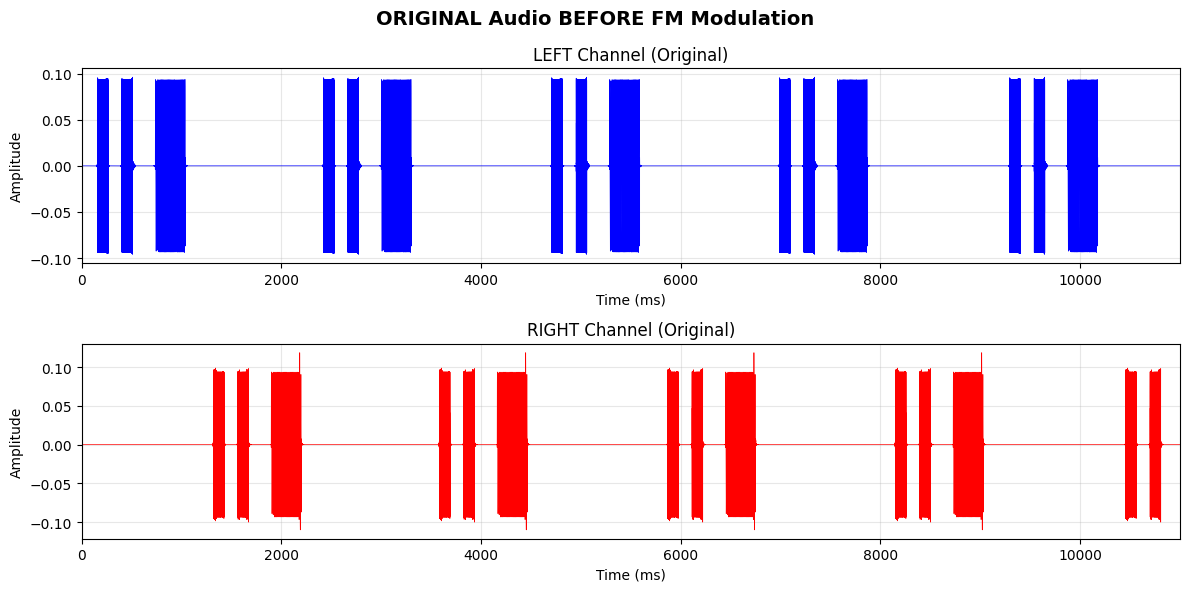

In [7]:
# Load the stereo audio
fs_audio, audio_data = wav.read('audio/stereo.wav')
audio_data = audio_data.astype(np.float64) / 32768.0  # Normalize

# Use full audio (11.68 seconds)
n_samples = len(audio_data)
left_orig = audio_data[:n_samples, 0]
right_orig = audio_data[:n_samples, 1]
t_audio = np.arange(n_samples) / fs_audio

print(f'Audio loaded: {len(left_orig)/fs_audio:.2f} seconds at {fs_audio} Hz')

# Visualize ORIGINAL Left and Right BEFORE modulation
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
fig.suptitle('ORIGINAL Audio BEFORE FM Modulation', fontsize=14, fontweight='bold')

axes[0].plot(t_audio * 1000, left_orig, 'b-', lw=0.5)
axes[0].set_title('LEFT Channel (Original)')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude')
axes[0].set_xlim([0, 11000])  # Show 20ms
axes[0].grid(True, alpha=0.3)

axes[1].plot(t_audio * 1000, right_orig, 'r-', lw=0.5)
axes[1].set_title('RIGHT Channel (Original)')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_xlim([0, 11000])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/task4_original_audio.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Process through FM stereo system with different filter orders
orders = [4, 8, 12]
results = {}

for order in orders:
    print(f'Processing with pilot filter order = {order}...')
    
    # Multiplex
    mux = StereoMultiplexer(output_fs=200000)
    composite, fs_composite = mux.multiplex(left_orig, right_orig, fs_audio)
    
    # FM Transmit
    tx = FMTransmitter(delta_f=75e3)
    fm_signal, _ = tx.transmit(composite, fs_composite)
    fm_noisy = add_awgn(fm_signal, snr_db=40)
    
    # FM Receive
    rx = FMReceiver(delta_f=75e3)
    composite_rx = rx.receive(fm_noisy, fs_composite)
    
    # Demultiplex
    demux = StereoDemultiplexer(pilot_bpf_order=order)
    left_rx, right_rx = demux.demultiplex(composite_rx, fs_composite)
    
    # Resample to original rate
    left_rx = signal.resample(left_rx, n_samples)
    right_rx = signal.resample(right_rx, n_samples)
    
    # Normalize for fair comparison
    left_rx = left_rx / np.max(np.abs(left_rx)) * np.max(np.abs(left_orig))
    right_rx = right_rx / np.max(np.abs(right_rx)) * np.max(np.abs(right_orig))
    
    # Calculate RMS error
    cut = int(0.1 * n_samples)
    left_err = np.sqrt(np.mean((left_rx[cut:-cut] - left_orig[cut:-cut])**2))
    right_err = np.sqrt(np.mean((right_rx[cut:-cut] - right_orig[cut:-cut])**2))
    
    results[order] = {'l_rx': left_rx, 'r_rx': right_rx, 'l_err': left_err, 'r_err': right_err}

# Print results table
print('\n' + '='*55)
print(f"{'Filter Order':<15} {'Left RMS Error':<20} {'Right RMS Error':<20}")
print('-' * 55)
for order in orders:
    print(f"{order:<15} {results[order]['l_err']:<20.4f} {results[order]['r_err']:<20.4f}")
print('='*55)

Processing with pilot filter order = 4...
Processing with pilot filter order = 8...
Processing with pilot filter order = 12...

Filter Order    Left RMS Error       Right RMS Error     
-------------------------------------------------------
4               0.0385               0.0430              
8               0.0389               0.0441              
12              0.0388               0.0453              


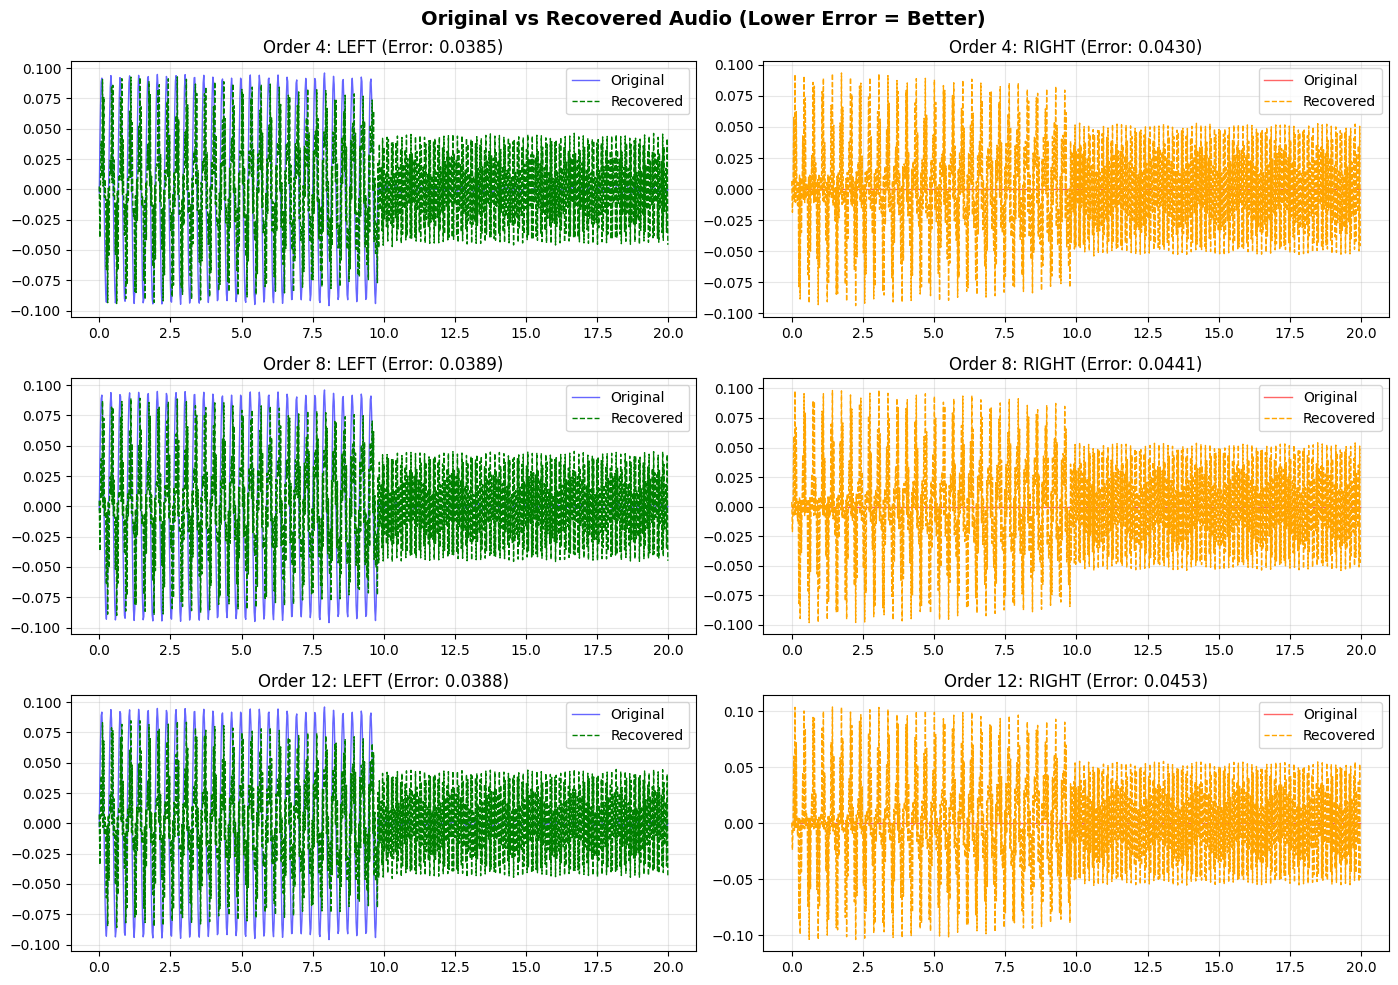

In [9]:
# Visualize Original vs Recovered for each filter order
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Original vs Recovered Audio (Lower Error = Better)', fontsize=14, fontweight='bold')

for i, order in enumerate(orders):
    res = results[order]
    
    # Show 20ms of audio starting at 500ms
    start = int(0.5 * fs_audio)
    n_pts = int(0.02 * fs_audio)
    t_plot = np.arange(n_pts) / fs_audio * 1000
    
    # Left channel
    axes[i, 0].plot(t_plot, left_orig[start:start+n_pts], 'b-', lw=1, alpha=0.6, label='Original')
    axes[i, 0].plot(t_plot, res['l_rx'][start:start+n_pts], 'g--', lw=1, label='Recovered')
    axes[i, 0].set_title(f"Order {order}: LEFT (Error: {res['l_err']:.4f})")
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Right channel
    axes[i, 1].plot(t_plot, right_orig[start:start+n_pts], 'r-', lw=1, alpha=0.6, label='Original')
    axes[i, 1].plot(t_plot, res['r_rx'][start:start+n_pts], 'orange', ls='--', lw=1, label='Recovered')
    axes[i, 1].set_title(f"Order {order}: RIGHT (Error: {res['r_err']:.4f})")
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

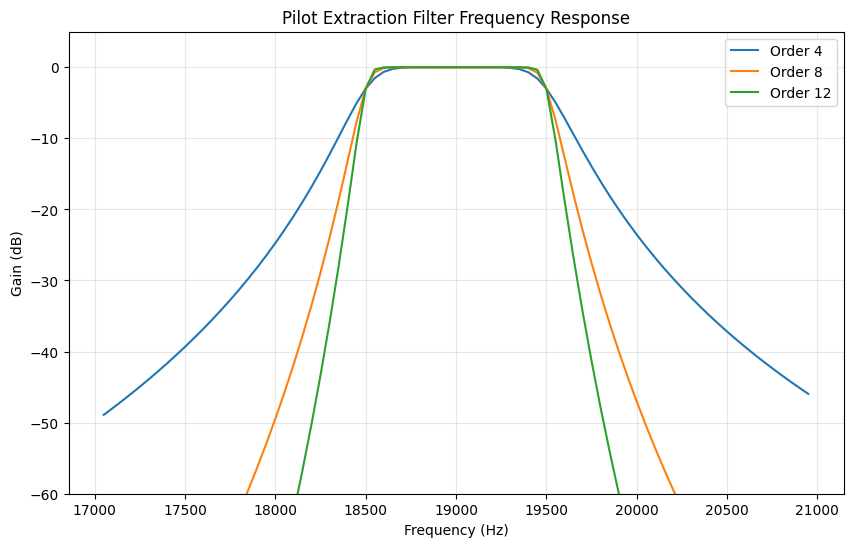

In [10]:
# Plot Filter Frequency Responses
fs = 200000
f_center = 19000
f_low = f_center - 500
f_high = f_center + 500

plt.figure(figsize=(10, 6))

for order in orders:
    sos = signal.butter(order, [f_low, f_high], btype='band', fs=fs, output='sos')
    w, h = signal.sosfreqz(sos, worN=2000, fs=fs)
    mask = (w > 17000) & (w < 21000)
    plt.plot(w[mask], 20 * np.log10(abs(h[mask])), label=f'Order {order}')

plt.title('Pilot Extraction Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.ylim(-60, 5)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Analysis

### c) Trade-offs of Filter Order

**Is higher order always better?** Not necessarily.

1. **Selectivity (Pro):** Higher order = steeper roll-off, better noise rejection
2. **Phase Distortion (Con):** Higher order = more group delay, phase errors
3. **Transient Response (Con):** Higher order = longer settling time

**Conclusion:** Balance is needed. Order 4-6 often provides the best trade-off.